<a href="https://colab.research.google.com/github/ruany-doehnert/Deforestation_Amazon/blob/main/ml_amazon_model_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# conect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Import Libraries and Load Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import numpy as np
from collections import Counter
import joblib

In [4]:
# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/earthengine_export/training_data_amazon_features.csv')
print(df.head())

   treecover      NDVI       NBR  elevation  label
0        100  0.408551  0.337988        182      1
1         97  0.416539  0.370001        218      1
2        100  0.271399  0.126345        145      1
3        100  0.388768  0.335218        151      1
4        100  0.381422  0.292019        168      1


In [5]:
df['treecover'] = df['treecover'].fillna(0)
df['label'] = df['label'].fillna(0)

In [6]:
print("label:", df['label'].value_counts())

label: label
1    1954
0      46
Name: count, dtype: int64


In [20]:
# Separate classes
df_majority = df[df.label == 1.0]
df_minority = df[df.label == 0.0]

# Downsample majority class
df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),
    random_state=28
)

# Combine and shuffle
df_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=28)

2. Prepare Features and Labels

In [21]:
X = df_balanced[['treecover', 'NDVI', 'NBR', 'elevation']]  # Add more features here if available
y = df_balanced['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

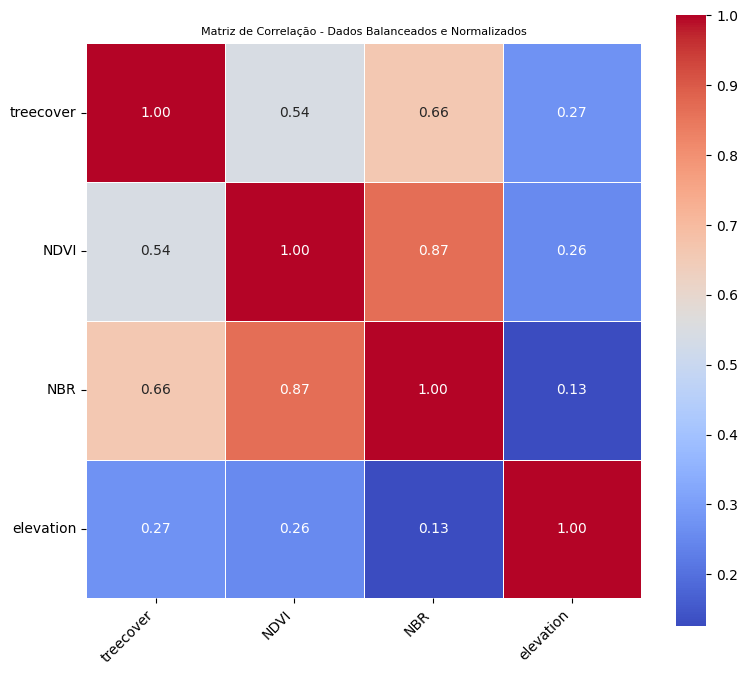

In [22]:
# Correlation Matrix (optional)
df_balanced = pd.DataFrame(X, columns=X.columns)
df_balanced['label'] = y

correlation_matrix = df_balanced[['treecover', 'NDVI', 'NBR', 'elevation']].corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Dados Balanceados e Normalizados', fontsize=8)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

3. Train a Random Forest Classifier

In [23]:
clf = RandomForestClassifier(n_estimators=6, random_state=28)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=6, random_state=28)

4. Evaluate the Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



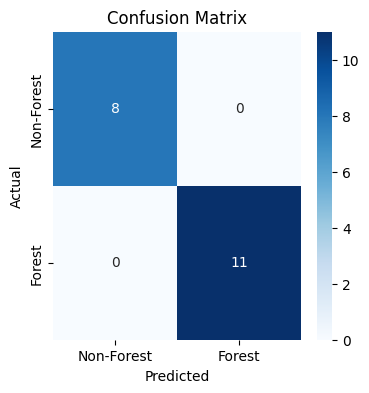

In [24]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Forest', 'Forest'], yticklabels=['Non-Forest', 'Forest'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

5. Feature Importance (Optional)

In [25]:
importances = clf.feature_importances_
for feat, imp in zip(X.columns, importances):
    print(f"{feat}: {imp:.3f}")

treecover: 0.568
NDVI: 0.067
NBR: 0.316
elevation: 0.049


In [26]:
# Save the trained model
# Save predictions with coordinates and features
results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = y_pred
results.to_csv('forest_predictions.csv', index=False)
print("✅ Predictions saved as forest_predictions.csv")
# Save model
joblib.dump(clf, '/content/drive/MyDrive/forest_rf_model.joblib')
# Save predictions
results.to_csv('/content/drive/MyDrive/forest_predictions.csv', index=False)

✅ Predictions saved as forest_predictions.csv
